In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2

def order_pics(pics):
    ordered_pics = []
    ordered_targ = []
    for i in range(len(pics)):
        num = i + 1
        for pic in pics:
            if int(pic.split('_')[1].replace('.jpg','')) == num:
                ordered_pics.append(pic)
                ordered_targ.append(num)
    return ordered_pics, ordered_targ

def load_images_from_folder(folder):
    images_train = []
    pics = os.listdir(folder)
    ordered_pics, ordered_targ = order_pics(pics)
    for filename, target in zip(ordered_pics, ordered_targ):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calculer le LBP de l'image
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')

        # Redimensionner en 80x80
        lbp = cv2.resize(lbp, (80, 80), interpolation=cv2.INTER_AREA)

        images_train.append([lbp, target])

    return images_train

In [ ]:
folder = 'C:\\Users\\eyach\\Desktop\\projetpython\\archive'
images_train = load_images_from_folder(folder)
print(images_train[:1]) # Afficher les premières données de la liste

[[array([[ 7.        ,  7.85714287,  8.71428573, ..., 10.0000003 ,
         9.857143  ,  9.        ],
       [ 7.        , 22.42857158, 14.28571403, ...,  7.57142881,
         8.85714298,  8.        ],
       [ 9.        ,  9.        ,  9.71428573, ..., 21.00000057,
        10.71428587,  9.        ],
       ...,
       [25.        , 25.        , 17.14285696, ..., 18.14285758,
         2.14285721,  9.        ],
       [25.        ,  7.85714269, 19.28571463, ...,  0.71428573,
         3.57142873, 25.        ],
       [ 7.        ,  5.28571427,  9.28571439, ...,  8.14285737,
         6.14285724,  7.        ]]), 1]]


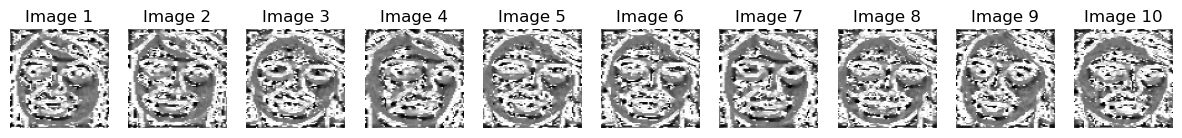

In [ ]:
import matplotlib.pyplot as plt

images = [img[0] for img in images_train if img[1] == 8][:]  # Sélectionner les 10 premières images de la catégorie petcat
# Créer une nouvelle figure pour chaque catégorie
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img, cmap='gray')  # Afficher chaque image
    ax.axis('off')  # Masquer les axes
    ax.set_title(f"Image {i+1}")  # Titre pour chaque image

plt.show()  # Afficher la figure contenant toutes les images de cette catégorie

In [ ]:
import numpy as np
img_size =80
img_data = []
img_target = []

for features, label in images_train:
    img_data.append(features)
    img_target.append(label)

img_data = np.array(img_data)
img_target = np.array(img_target)

print('Data shape:', img_data.shape)
print('Target shape:', img_target.shape)
img_data = np.array(img_data).reshape(-1, img_size, img_size, 1)
img_target = np.array(img_target)

Data shape: (410, 80, 80)
Target shape: (410,)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(img_data, img_target, test_size=0.3, random_state=42)

In [ ]:
from keras.utils import to_categorical

# Convertir les étiquettes en format catégorique
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

# Initialistion nombre des classes
num_classes = 42

# Initialistion a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())


# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(num_classes, activation='softmax'))

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)


history = model.fit(X_train, y_train_categorical, batch_size=32, epochs=20, validation_data=(X_test, y_test_categorical))

# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Test Accuracy:", accuracy)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.0252 - loss: 7.5993 - val_accuracy: 0.0163 - val_loss: 6.4142
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.0471 - loss: 6.3757 - val_accuracy: 0.0244 - val_loss: 8.2042
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.1967 - loss: 3.9564 - val_accuracy: 0.0244 - val_loss: 7.5701
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.2682 - loss: 3.1810 - val_accuracy: 0.0244 - val_loss: 8.9196
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.4924 - loss: 2.0398 - val_accuracy: 0.0407 - val_loss: 12.1392
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.5855 - loss: 1.4660 - val_accuracy: 0.0650 - val_loss: 9.6604
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.6640 - loss: 1.1949 - val_accuracy: 0.0488 - val_loss: 10.8148
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.8043 - loss: 0.6856 - val_accuracy: 0.0569 - val_los

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


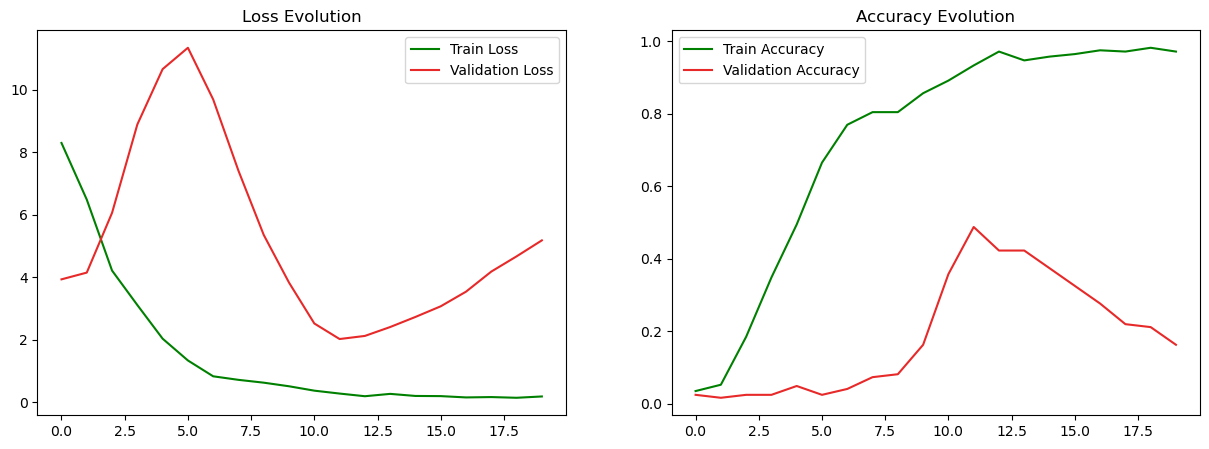

In [ ]:
plt.figure(figsize=(15,5))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='Green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#E72929')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='Green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#E72929')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [ ]:
import os
import cv2
import numpy as np
from skimage import feature

# Charger l'image que vous souhaitez classer
nouveau_dossier_images = 'C:\\Users\\eyach\\Desktop\\projetpython\\test'

# Liste pour stocker les images prétraitées
nouvelles_images = []

# Parcourir les images dans le dossier
for img_file in os.listdir(nouveau_dossier_images):
    img_path = os.path.join(nouveau_dossier_images, img_file)

    # Lire l'image et la redimensionner
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (80, 80))

    # Calculer LBP (Local Binary Patterns) de l'image
    radius = 3
    num_points = 8 * radius
    lbp_img = feature.local_binary_pattern(img, num_points, radius, method='uniform')

    # Normalisation de l'image LBP
    lbp_img = lbp_img / np.max(lbp_img)

    # Ajouter une dimension supplémentaire pour correspondre à la forme attendue du modèle (batch_size, height, width, channels)
    lbp_img = np.expand_dims(lbp_img, axis=-1)

    # Ajouter l'image prétraitée à la liste
    nouvelles_images.append(lbp_img)

# Convertir la liste en un tableau numpy
nouvelles_images = np.array(nouvelles_images)

# Utiliser un modèle pour faire des prédictions sur les images prétraitées (assumant que 'model' est défini ailleurs)
predictions = model.predict(nouvelles_images)

# Afficher les prédictions
for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    print("Classe prédite :", predicted_class_index)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Classe prédite : 19
